# Regression with a Tabular Gemstone Price Dataset
### Playground Series - Season 3, Episode 8
https://www.kaggle.com/competitions/playground-series-s3e8

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import skew
from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score

from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split

# linear models
from sklearn.linear_model import Ridge, LinearRegression, Lars, BayesianRidge, Perceptron, SGDRegressor
from sklearn.linear_model import RidgeCV, ElasticNet, LassoCV, LassoLarsCV, OrthogonalMatchingPursuit, ARDRegression
from sklearn.linear_model import PassiveAggressiveClassifier, TheilSenRegressor, HuberRegressor, GammaRegressor

# tree models
from sklearn.tree import ExtraTreeRegressor, DecisionTreeRegressor

# svm models
from sklearn.svm import LinearSVR, NuSVR, SVR

# closed neural network models
from sklearn.neural_network import MLPRegressor

# ensemble models
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# others
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# stack
from mlxtend.regressor import StackingCVRegressor

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
print(f'train.shape = {train.shape}\ntest.shape = {test.shape}')

train.shape = (193573, 11)
test.shape = (129050, 10)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193573 entries, 0 to 193572
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       193573 non-null  int64  
 1   carat    193573 non-null  float64
 2   cut      193573 non-null  object 
 3   color    193573 non-null  object 
 4   clarity  193573 non-null  object 
 5   depth    193573 non-null  float64
 6   table    193573 non-null  float64
 7   x        193573 non-null  float64
 8   y        193573 non-null  float64
 9   z        193573 non-null  float64
 10  price    193573 non-null  int64  
dtypes: float64(6), int64(2), object(3)
memory usage: 16.2+ MB


In [5]:
train['cut'].value_counts()

cut
Ideal        92454
Premium      49910
Very Good    37566
Good         11622
Fair          2021
Name: count, dtype: int64

In [6]:
train['color'].value_counts()

color
G    44391
E    35869
F    34258
H    30799
D    24286
I    17514
J     6456
Name: count, dtype: int64

In [7]:
train['clarity'].value_counts()

clarity
SI1     53272
VS2     48027
VS1     30669
SI2     30484
VVS2    15762
VVS1    10628
IF       4219
I1        512
Name: count, dtype: int64

In [8]:
all_data = pd.concat((train.loc[:, 'carat':'z'], test.loc[:, 'carat':'z']))

In [9]:
train['price'] = np.log1p(train['price'])

In [10]:
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna()))

skewed_feats = skewed_feats[skewed_feats > 0.75]

skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) 

In [11]:
all_data = pd.get_dummies(all_data)

In [12]:
all_data = all_data.fillna(all_data.median())

In [13]:
all_data.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [15]:
# criando treino
X = all_data[:train.shape[0]]

# criando o teste
test = all_data[train.shape[0]:]

# criando o target
y = train.price

# normalizando treino e teste
# X = scale(X)
# test = scale(test)

In [16]:
results = {
    'Model':[],
    'MAE':[],
    'RMSE':[],
    'EVS':[]
}

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [18]:
model_instances = [
    # LINEAR
    (Ridge(), 'Ridge'), 
    (RidgeCV(), 'Ridge CV'),
    (LassoCV(), 'LASSO CV'),
    (LinearRegression(), 'Linear Regression'),
    (BayesianRidge(), 'Bayesian Rigde'),
    (ElasticNet(), 'Elastic Net'),
    (OrthogonalMatchingPursuit(), 'Orthogonal Matching Pursuit'),
    (ARDRegression(), 'ARD Regression'),
    # TREE
    (ExtraTreeRegressor(), 'Extra Tree'),
    (DecisionTreeRegressor(), 'Decision Tree'),
    # SVM
    (LinearSVR(max_iter=100), 'Linear SVR'),
    (NuSVR(max_iter=100), 'NuSVR'),
    (SVR(max_iter=100), 'SVR'),
    # NN
    (MLPRegressor(max_iter=100, activation='tanh'), 'MLPRegressor'), # 1000 and 10000 hasn't converged
    # BOOST
    (AdaBoostRegressor(), 'Ada boost'),
    (BaggingRegressor(), 'Bagging'),
    (GradientBoostingRegressor(n_estimators=700), 'Gradient Boosting'),
    (RandomForestRegressor(), 'Random Forest'),
    # State of Art
    (XGBRegressor(learning_rate=0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,nthread=4,scale_pos_weight=1,
                     reg_alpha=0.00006), 'XGBoost'),
    (LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319,
                              feature_fraction_seed=9, bagging_seed=9,verbose=0,
                              min_data_in_leaf=6, min_sum_hessian_in_leaf=11), 'LightGBM'),
    (CatBoostRegressor(verbose=False), 'CatBoost'),
]

In [19]:
for model, model_name in model_instances:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results['Model'].append(model_name)
    results['MAE'].append(mean_absolute_error(y_test, y_pred))
    results['RMSE'].append(mean_squared_error(y_test, y_pred, squared=True))
    results['EVS'].append(explained_variance_score(y_test, y_pred))

c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.648e+01, tolerance: 1.512e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\gabri\Documents\UFTM\Introdução à Ciência de Dados\env\Lib\site-packages\sklearn\svm\_base.py:299: ConvergenceWarning: Solver termin

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, m

In [20]:
results = pd.DataFrame(results)
results

,Model,MAE,RMSE,EVS
0,Ridge,0.104502,0.021076,0.979649
1,Ridge CV,0.105234,0.021026,0.979697
2,LASSO CV,0.118995,0.024975,0.975885
3,Linear Regression,0.104433,0.021092,0.979634
4,Bayesian Rigde,0.104438,0.021092,0.979634
5,Elastic Net,0.502803,0.349789,0.662249
6,Orthogonal Matching Pursuit,0.181956,0.055433,0.946477
7,ARD Regression,0.104868,0.021259,0.979472
8,Extra Tree,0.106881,0.022924,0.977867
9,Decision Tree,0.107600,0.023247,0.977554


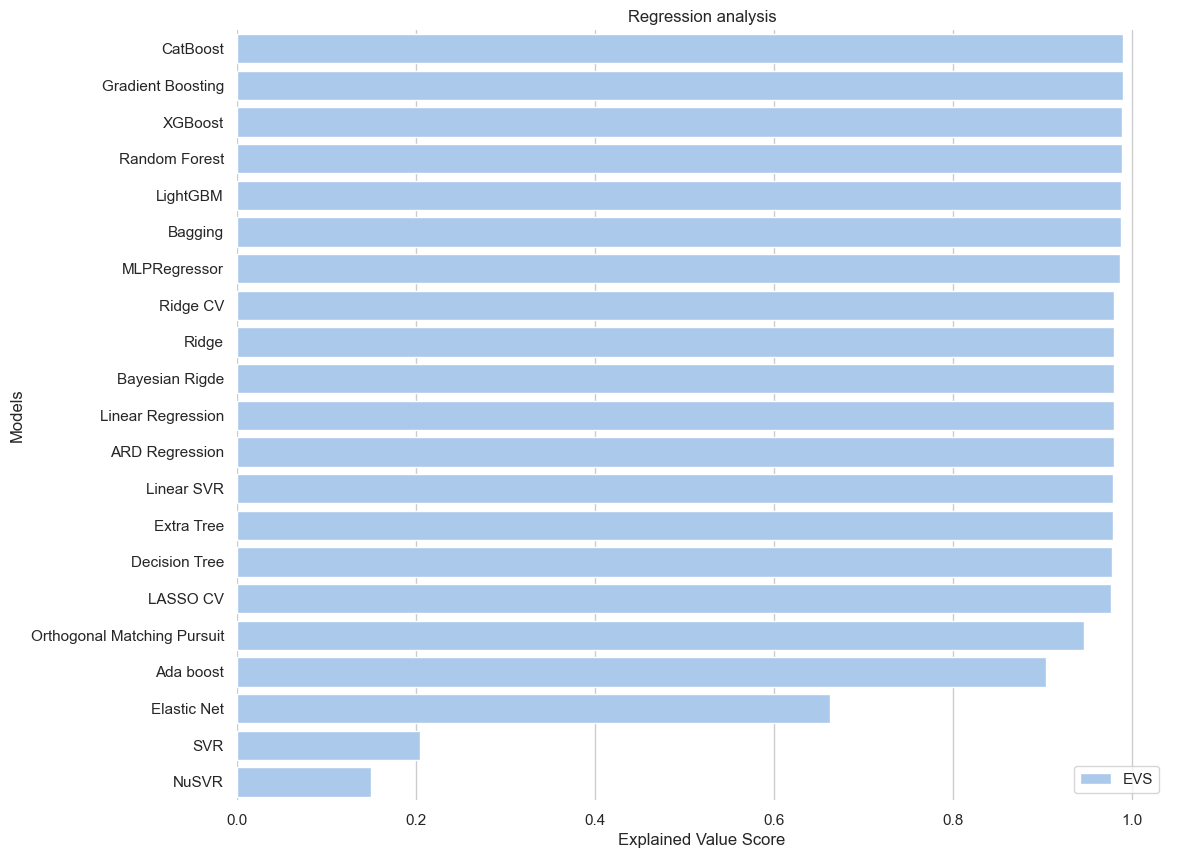

In [21]:
sns.set(style='whitegrid')
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes('pastel')
results_temp = results.sort_values('EVS', ascending=False)
sns.barplot(x='EVS', y='Model', data=results_temp,
            label='EVS', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='lower right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Explained Value Score',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

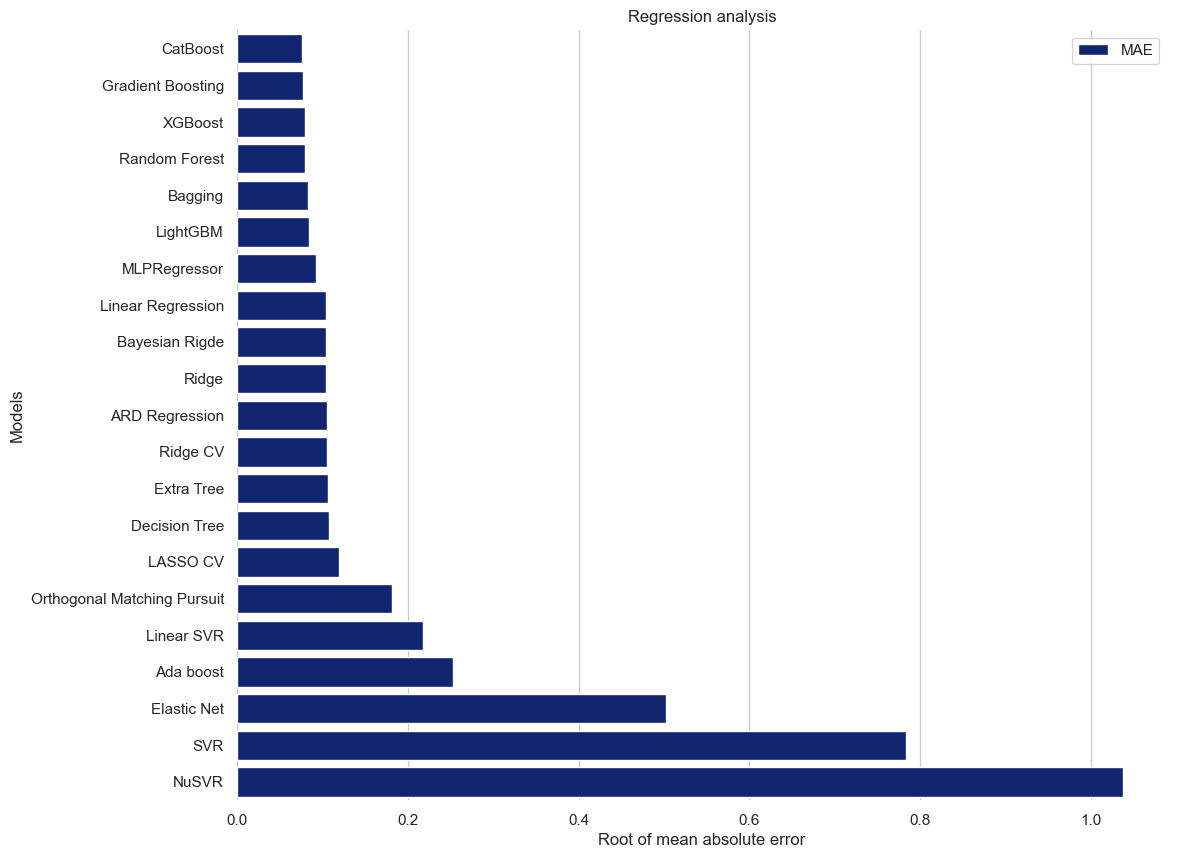

In [22]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes('dark')
results_temp = results.sort_values('MAE', ascending=True)
sns.barplot(x='MAE', y='Model', data=results_temp,
            label='MAE', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Root of mean absolute error',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

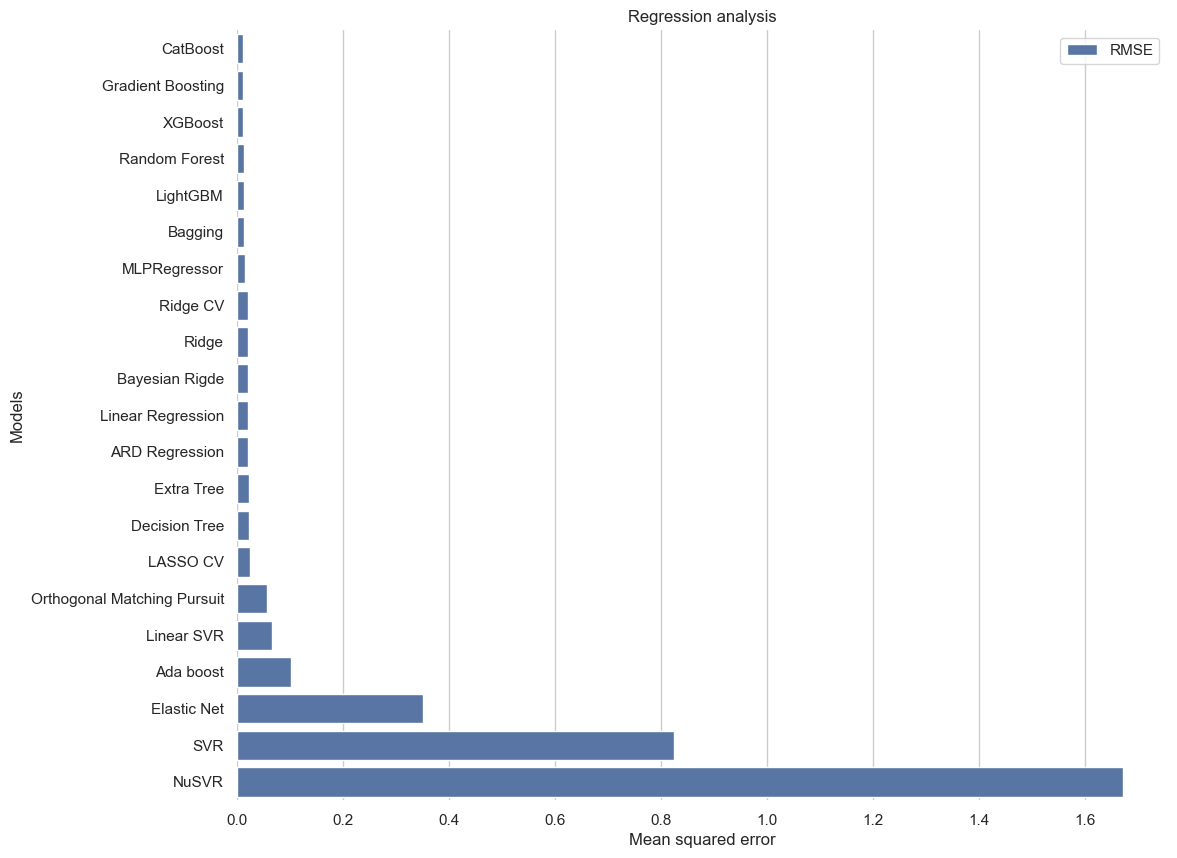

In [23]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 10))
# Plot the total crashes
sns.set_color_codes()
results_temp = results.sort_values('RMSE', ascending=True)
sns.barplot(x='RMSE', y='Model', data=results_temp,
            label='RMSE', color='b')
# Add a legend and informative axis label
ax.legend(ncol=2, loc='upper right', frameon=True)
ax.set(ylabel='Models',
       xlabel='Mean squared error',title='Regression analysis')
sns.despine(left=True, bottom=True)
plt.show()

In [24]:
results_temp = results.sort_values('EVS', ascending=False)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
19             LightGBM
Name: Model, dtype: object

In [25]:
results_temp = results.sort_values('MAE', ascending=True)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
15              Bagging
Name: Model, dtype: object

In [26]:
results_temp = results.sort_values('RMSE', ascending=True)
results_temp.iloc[:5]['Model']

20             CatBoost
16    Gradient Boosting
18              XGBoost
17        Random Forest
19             LightGBM
Name: Model, dtype: object

In [27]:
cat = CatBoostRegressor(verbose=False)

grad = GradientBoostingRegressor(n_estimators=700)

xgb = XGBRegressor(learning_rate =0.01, n_estimators=3460, max_depth=3,
                     min_child_weight=0 ,gamma=0, subsample=0.7,
                     colsample_bytree=0.7,nthread=4,scale_pos_weight=1,
                     reg_alpha=0.00006)

stack_gen=StackingCVRegressor(
    regressors=(cat, grad, xgb),
    meta_regressor=cat,
    use_features_in_secondary=True)

In [30]:
stack_gen.fit(X.values, y.values)
price_prediction = stack_gen.predict(test.values)

In [31]:
sample_submission = pd.read_csv('sample_submission.csv', index_col=0)
sample_submission['price'] = np.expm1(price_prediction)
sample_submission.to_csv('price_prediction.csv')